In [ ]:
# @title Variational Auto Encoder Implemented on HAM10000

In [ ]:
# @title Project done by: Sofia Guerrero and Nayara Vasques

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_root = '/content/drive/MyDrive/HAM10000_images_part_1'

In [ ]:
#This part 1 includes 5000 images.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os


In [ ]:
# @title Loading the Dataset

Epoch 1/100, Loss: 246953.2820564516
Epoch 2/100, Loss: 237239.94027217742
Epoch 3/100, Loss: 233829.8306451613
Epoch 4/100, Loss: 232773.92076612904
Epoch 5/100, Loss: 232186.7019657258
Epoch 6/100, Loss: 231949.33881048387
Epoch 7/100, Loss: 231633.0472278226
Epoch 8/100, Loss: 231449.5439516129
Epoch 9/100, Loss: 231375.7113407258
Epoch 10/100, Loss: 231227.3302923387
Epoch 11/100, Loss: 231194.30378024193
Epoch 12/100, Loss: 231097.7782762097
Epoch 13/100, Loss: 231064.51648185484
Epoch 14/100, Loss: 230987.42731854838
Epoch 15/100, Loss: 230974.18548387097
Epoch 16/100, Loss: 230980.02943548388
Epoch 17/100, Loss: 230852.83155241935
Epoch 18/100, Loss: 230821.82192540323
Epoch 19/100, Loss: 230914.13840725805
Epoch 20/100, Loss: 230824.98739919355
Epoch 21/100, Loss: 230784.1966733871
Epoch 22/100, Loss: 230736.1733870968
Epoch 23/100, Loss: 230761.0929435484
Epoch 24/100, Loss: 230677.0673891129
Epoch 25/100, Loss: 230691.34611895162
Epoch 26/100, Loss: 230664.05861895162
Epoch 2

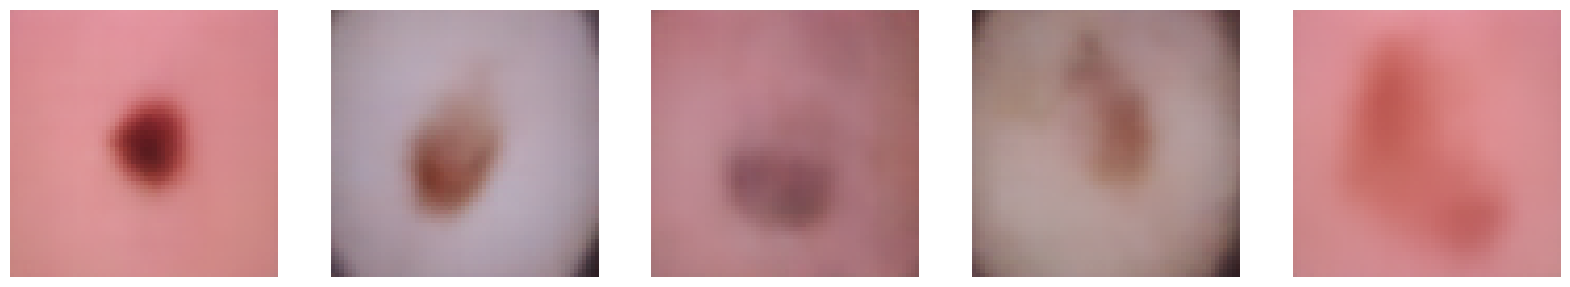

In [ ]:

class CustomDataset(Dataset):
    def __init__(self, data_root, transform=None):
        self.data_root = data_root
        self.image_paths = os.listdir(data_root)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_root, self.image_paths[idx])
        image = Image.open(img_name).convert("RGB")  # Convert image to RGB
        if self.transform:
            image = self.transform(image)
        return image

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 2 * latent_dim),  # Two outputs for mean and variance
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Sigmoid activation to output values between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode input
        encoded = self.encoder(x)
        # Split the output into mean and logvar
        mu, logvar = torch.chunk(encoded, 2, dim=1)
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        # Decode
        decoded = self.decoder(z)
        return decoded, mu, logvar

# Function to train the VAE
def train_vae(vae_model, train_loader, optimizer, criterion, num_epochs):
    vae_model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae_model(data)
            # Compute reconstruction loss and KL divergence
            reconstruction_loss = criterion(recon_batch, data)
            kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = reconstruction_loss + kl_divergence
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

# Function to generate images from the VAE
def generate_images(vae_model, num_images=5):
    generated_images = []
    with torch.no_grad():
        for _ in range(num_images):
            z = torch.randn(1, latent_dim)  # Sample from latent space
            generated_img = vae_model.decoder(z)  # Generate image from latent vector using the decoder
            generated_images.append(generated_img.numpy())

    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        img = generated_images[i].squeeze()  # Remove the batch dimension
        axes[i].imshow(np.transpose(img, (1, 2, 0)))  # Transpose to (H, W, C) for displaying RGB images
        axes[i].axis('off')
    plt.show()

# Define hyperparameters
latent_dim = 120
batch_size = 32
learning_rate = 1e-3
num_epochs = 100

# Create a dataset and DataLoader
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert images to tensors
])
dataset = CustomDataset(data_root, transform=transform)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create the VAE model, optimizer, and loss function
vae_model = VAE(latent_dim)
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')  # Binary cross-entropy loss for reconstruction

# Train the VAE
train_vae(vae_model, train_loader, optimizer, criterion, num_epochs)

# Generate images using the trained VAE
generate_images(vae_model, num_images=5)

In [ ]:
#time 2h 27min
# conv added which in comparison with the linear layer we can see the difference. (Check also the difference beteen the architectures)